In [89]:
import os
import copy
import juliet
import dynesty
import numpy as np
import pandas as pd
import seaborn as sns
import lightkurve as lk
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.ticker import AutoMinorLocator
from astropy.timeseries import LombScargle
from astropy.time import Time

In [65]:
path = '/home/alexandert/Docs_Jupyter/9.Joven_Investigador/Datos_Juliet'
os.chdir(path)
#2459616.73644604	315638.400	13.000	FIDEOS

In [66]:
folder = '/home/alexandert/Docs_Jupyter/9.Joven_Investigador/Datos_Juliet'

rvfile= 'fideos.txt'

#targ bjd rv e_rv instr

bjd = []
rv = []
e_rv = []
instr = []

# open file for reading
with open(rvfile, 'r') as f:
    for line in f.readlines():
        if "#" not in line:
            data = line.split()
            bjd.append(np.float64(data[0])-2457000)
            rv.append(np.float64(data[1]))
            e_rv.append(np.float64(data[2]))
            instr.append(data[3])

In [90]:
priors = {}

# Name of the parameters to be fit:
params = ['P_p1','t0_p1','mu_FIDEOS', \
          'K_p1', 'ecc_p1', 'omega_p1', 'sigma_w_FIDEOS']

# Distributions:
dists = ['normal','normal','normal', \
         'uniform','uniform', 'uniform', 'loguniform']

# Hyperparameters


hyperps = [[10.5 ,0.5], [2459657.62,0.01], [30699,10], \
           [60.,80.], [0.,0.5], [0.,200.], [0.1, 100.]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

dataset = juliet.load(priors = priors, rvfilename='fideos.txt', out_folder = 'fideos_rvs')
results = dataset.fit(n_live_points = 300)

PyMultinest installation not detected. Forcing dynesty as the sampler.


19696it [04:16, 76.66it/s, +300 | bound: 417 | nc: 1 | ncall: 513125 | eff(%):  3.899 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-  0.533 | dlogz:  0.001 >  0.309]


In [91]:
# np.mean(rv)-min(rv) , max(rv)-np.mean(rv)

In [92]:
# min(rv),max(rv)

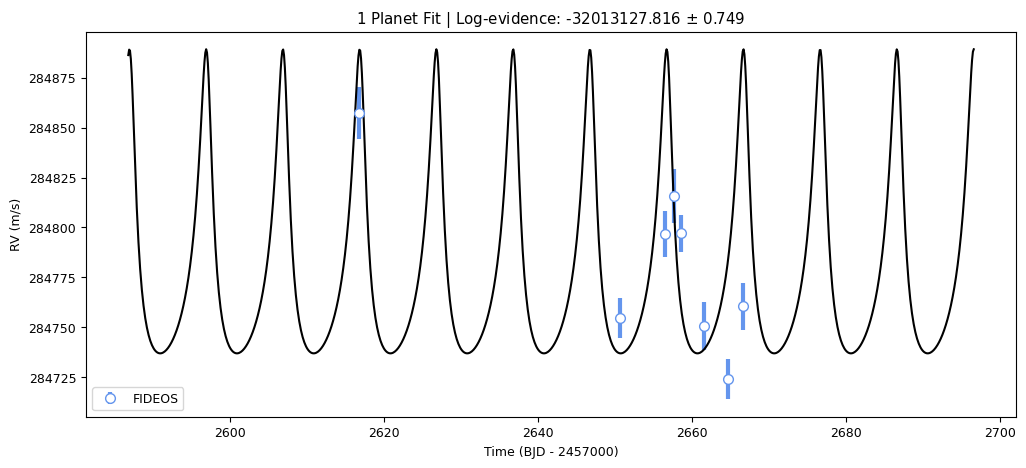

In [97]:
# Plot HARPS and FEROS datasets in the same panel. For this, first select any
# of the two and substract the systematic velocity to get the Keplerian signal.
# Let's do it with FEROS. First generate times on which to evaluate the model:
min_time, max_time = np.min(dataset.times_rv['FIDEOS'])-30,\
                     np.max(dataset.times_rv['FIDEOS'])+30

model_times = np.linspace(min_time,max_time,1000)

# Now evaluate the model in those times, and substract the systemic-velocity to
# get the Keplerian signal:
keplerian = results.rv.evaluate('FIDEOS', t = model_times) - \
            np.median(results.posteriors['posterior_samples']['mu_FIDEOS'])

# Now plot the (systematic-velocity corrected) RVs:
fig = plt.figure(figsize=(12,5))
instruments = ['FIDEOS']
colors = ['cornflowerblue','orangered']
for i in range(len(instruments)):
    instrument = instruments[i]
    # Evaluate the median jitter for the instrument:
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    # Evaluate the median systemic-velocity:
    mu = np.median(results.posteriors['posterior_samples']['mu_'+instrument])
    #Plot original data with original errorbars:
    plt.errorbar(dataset.times_rv[instrument]-2457000,(dataset.data_rv[instrument]-mu),\
                 yerr = dataset.errors_rv[instrument],fmt='o',\
                 mec=colors[i], ecolor=colors[i], elinewidth=3, mfc = 'white', \
                 ms = 7, label=instrument, zorder=10)

    # Plot original errorbars + jitter (added in quadrature):
    # plt.errorbar(dataset.times_rv[instrument]-2457000,dataset.data_rv[instrument]-mu,\
    #             yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2),fmt='o',\
    #             mec=colors[i], ecolor=colors[i], mfc = 'white', label=instrument,\
    #             alpha = 0.5, zorder=5)

# Plot Keplerian model:
#plt.plot(model_times-2457000,keplerian,color='black',zorder=10)
plt.plot(model_times-2457000,keplerian + np.median(rv) - mu,color='k',zorder=10)

plt.ylabel('RV (m/s)')
plt.xlabel('Time (BJD - 2457000)')
plt.title('1 Planet Fit | Log-evidence: {0:.3f} $\pm$ {1:.3f}'.format(results.posteriors['lnZ'],\
            results.posteriors['lnZerr']))
#plt.xlim([-90-4.8543e6,-30-4.8543e6])
#plt.xlim([-398-4.8543e6,-378-4.8543e6])
plt.legend()